# Monte Carlo Simulations

**Goal**: Estimate numerical results using random sampling when analytical solutions are intractable.

**Use Cases**:
- Option pricing in finance
- Risk estimation and forecasting
- Probabilistic integrals and expectations
- Stochastic process simulation
- Bayesian inference

**Core Steps**:
1. Define a model or system with randomness
2. Generate a large number of random samples
3. Compute the quantity of interest for each sample
4. Aggregate results (mean, variance, percentiles)

**Key Concepts**:
- Law of large numbers
- Random sampling
- Variance reduction techniques
- Convergence diagnostics
- Reproducibility


## What Are Monte Carlo Simulations?

Monte Carlo (MC) methods use **random sampling** to approximate solutions to problems that are **deterministic in principle but analytically intractable**.

---

### Examples

1. **Estimate $\pi$**:
   Simulate random points in a square, check how many fall in an inscribed circle.

2. **Estimate expected return of a portfolio**:
   Simulate many future market paths under assumptions, average returns.

3. **Compute definite integrals**:
   Replace integral by average over sampled points:
   $$
   \int_a^b f(x)\,dx \approx \frac{b-a}{N} \sum_{i=1}^N f(x_i)
   $$

---

### Law of Large Numbers

As $N \to \infty$:
$$
\frac{1}{N} \sum_{i=1}^N f(x_i) \to \mathbb{E}[f(x)]
$$

The **accuracy improves slowly**: standard error $\sim \mathcal{O}(1/\sqrt{N})$

---

### Sources of Randomness

- Use `numpy.random` for reproducibility (set seeds)
- Uniform, normal, Poisson, etc.
- You can simulate discrete or continuous systems

---

### Common Use Cases in Finance

- Value at Risk (VaR)
- Option pricing (Black-Scholes, American options)
- Simulating asset paths (GBM, mean-reverting)
- Stress testing under multiple scenarios


Estimated π: 3.10680


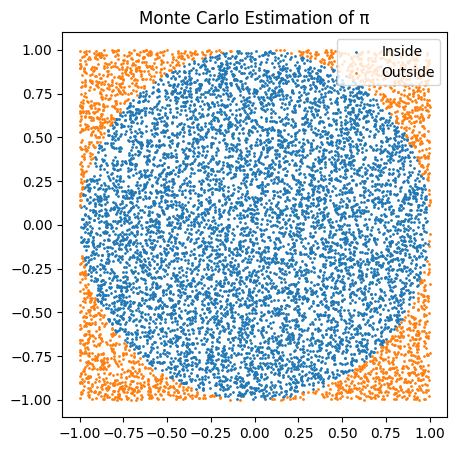

In [1]:
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(0)
N = 10_000
x = np.random.uniform(-1, 1, N)
y = np.random.uniform(-1, 1, N)
inside_circle = x**2 + y**2 <= 1

pi_estimate = 4 * np.mean(inside_circle)
print(f"Estimated π: {pi_estimate:.5f}")

# Visualization
plt.figure(figsize=(5,5))
plt.scatter(x[inside_circle], y[inside_circle], s=1, label='Inside')
plt.scatter(x[~inside_circle], y[~inside_circle], s=1, label='Outside')
plt.gca().set_aspect('equal')
plt.title("Monte Carlo Estimation of π")
plt.legend()
plt.show()


In [2]:
# Estimate integral of sin(x) from 0 to pi
a, b = 0, np.pi
N = 100_000
x = np.random.uniform(a, b, N)
f_x = np.sin(x)
est = (b - a) * np.mean(f_x)
print(f"Estimated ∫sin(x)dx from 0 to π: {est:.5f}")


Estimated ∫sin(x)dx from 0 to π: 1.99764


## Monte Carlo Simulation for European Option Pricing

Monte Carlo simulation can be used to estimate the **expected payoff** of an option under the **risk-neutral measure**.

---

### Black-Scholes Model for Stock Price

Under risk-neutral pricing:
$$
S_T = S_0 \cdot \exp \left( \left(r - \frac{\sigma^2}{2}\right)T + \sigma \sqrt{T} \cdot Z \right)
$$

Where:
- $S_0$ = initial stock price
- $r$ = risk-free rate
- $\sigma$ = volatility
- $T$ = time to maturity
- $Z \sim \mathcal{N}(0,1)$

---

### European Call Option Price:

$$
C = e^{-rT} \cdot \mathbb{E} \left[ \max(S_T - K, 0) \right]
$$

We simulate $N$ paths of $S_T$ and compute the average discounted payoff.

---

### Assumptions

- No dividends
- Constant volatility and risk-free rate
- Lognormal distribution of returns


In [3]:
import numpy as np

# Parameters
S0 = 100     # initial stock price
K = 110      # strike price
T = 1.0      # time to maturity (1 year)
r = 0.05     # risk-free rate
sigma = 0.2  # volatility
N = 100_000  # number of simulations

# Simulate final price under risk-neutral measure
np.random.seed(42)
Z = np.random.normal(0, 1, N)
ST = S0 * np.exp((r - 0.5 * sigma**2) * T + sigma * np.sqrt(T) * Z)

# Compute discounted payoff
payoff = np.maximum(ST - K, 0)
price = np.exp(-r * T) * np.mean(payoff)

print(f"Estimated Call Option Price: {price:.4f}")


Estimated Call Option Price: 6.0603


## Value at Risk (VaR) and Conditional Value at Risk (CVaR)

These are **risk measures** used in quantitative finance to estimate **potential losses** of a portfolio under adverse conditions.

---

### 1. Value at Risk (VaR)

**Definition**: At confidence level $\alpha$ (e.g., 95% or 99%), the Value at Risk is the threshold loss level such that:
$$
P(\text{Loss} \leq \text{VaR}_\alpha) = \alpha
$$

In other words:
- 95% VaR = loss exceeded only 5% of the time
- It is a **quantile of the loss distribution**

---

### 2. Conditional Value at Risk (CVaR) or Expected Shortfall

**Definition**: The **expected loss** **given** that the loss exceeds the VaR:
$$
\text{CVaR}_\alpha = \mathbb{E}[\text{Loss} \mid \text{Loss} > \text{VaR}_\alpha]
$$

- CVaR is always **greater than or equal to** VaR
- More robust for optimization and coherent risk measure

---

### Monte Carlo Approach:

1. Simulate $N$ future portfolio returns under risk-neutral or real-world model
2. Compute **losses**: $\text{Loss} = -\text{Return}$
3. Sort the losses
4. Estimate:
   - $\text{VaR}_\alpha$ as the $(1 - \alpha)$-quantile of losses
   - $\text{CVaR}_\alpha$ as the mean of losses beyond VaR

---

### Notes:
- Use **log-returns or PnL samples**
- Works for any portfolio, even nonlinear (e.g., options)
- Requires many simulations for stable estimates

In [4]:
import numpy as np

# Parameters
mu = 0.05          # expected return (annualized)
sigma = 0.2        # volatility
T = 1              # 1 year
S0 = 1_000_000     # portfolio value
N = 100_000        # number of simulations
alpha = 0.95       # confidence level

# Simulate log-returns (assuming normality)
np.random.seed(0)
Z = np.random.normal(0, 1, N)
log_returns = (mu - 0.5 * sigma**2) * T + sigma * np.sqrt(T) * Z
returns = np.exp(log_returns) - 1
portfolio_values = S0 * (1 + returns)

# Compute losses
losses = S0 - portfolio_values
losses_sorted = np.sort(losses)

# Estimate VaR and CVaR
var_index = int((1 - alpha) * N)
VaR = losses_sorted[var_index]
CVaR = losses_sorted[:var_index].mean()

print(f"{int(alpha*100)}% VaR:  ${VaR:,.2f}")
print(f"{int(alpha*100)}% CVaR: ${CVaR:,.2f}")


95% VaR:  $-431,747.80
95% CVaR: $-560,318.46


## Interpretation and Tips

- A 95% VaR of $50,000 means that **you will not lose more than $50K with 95% confidence** in the given time horizon.
- CVaR might be $80K → when you do exceed VaR, the average loss is even worse.
- For heavy-tailed distributions, VaR **underestimates risk** → CVaR is preferred.
- Always simulate **log-returns**, not linear returns, for better stability.

---

### Extensions

- Use historical sampling (bootstrapping) instead of normal assumption
- Simulate **correlated multivariate returns** (e.g., across assets)
- Apply to option portfolios using Black-Scholes or Heston dynamics


## Variance Reduction in Monte Carlo Simulations

Monte Carlo estimates converge as $\mathcal{O}(1/\sqrt{N})$, which is slow. To get accurate results with fewer samples, we can reduce the **variance** of the estimator without introducing bias.

---

### 1. Antithetic Variates

**Idea**: Use negatively correlated random variables to cancel out noise.

- For each sample $Z \sim \mathcal{N}(0,1)$, also use $-Z$
- Averaging these two samples often reduces variance

**Use case**: Black-Scholes option pricing, symmetric functions (like max, exp)

---

### 2. Control Variates

**Idea**: Use another variable with **known expectation** that is correlated with your target.

Let:
- $Y$: original estimator
- $C$: control variable with known $\mathbb{E}[C]$
- Then:
$$
\hat{Y}_{cv} = Y - \beta (C - \mathbb{E}[C])
$$

- Choose $\beta$ to minimize variance:
$$
\beta^* = \frac{\text{Cov}(Y, C)}{\text{Var}(C)}
$$

---

### 3. Importance Sampling

**Idea**: Sample from a different distribution that emphasizes important regions.

Let:
- $p(x)$: original distribution
- $q(x)$: importance distribution
Then:
$$
\mathbb{E}_p[f(x)] = \int f(x) \frac{p(x)}{q(x)} q(x) dx
$$

This is used to focus on rare events (e.g., tail risk in VaR), but requires care to avoid bias or instability.

---

### 4. Stratified Sampling

**Idea**: Divide input space into strata (bins) and sample from each one.

- Helps reduce sampling error due to imbalance in sample coverage
- Useful when function has varying variance across regions

---

### Summary Table

| Technique         | Best For                     | When to Use                     |
|------------------|------------------------------|----------------------------------|
| Antithetic        | Symmetric functions          | Pricing options, basic integrals |
| Control Variates  | Known related expectations   | Finance (e.g., $\mathbb{E}[S_T] = S_0 e^{rT}$) |
| Importance Sampling | Rare events                | Tail risk, VaR, rare failures    |
| Stratified        | Varying function variance    | Spatial models, integrals        |


In [5]:
# Baseline Black-Scholes Monte Carlo
def bs_mc_call(S0, K, T, r, sigma, N):
    Z = np.random.normal(0, 1, N)
    ST = S0 * np.exp((r - 0.5*sigma**2)*T + sigma*np.sqrt(T)*Z)
    payoff = np.maximum(ST - K, 0)
    return np.exp(-r*T) * np.mean(payoff)

# Antithetic Variates version
def bs_mc_call_antithetic(S0, K, T, r, sigma, N):
    Z = np.random.normal(0, 1, N)
    Z_pair = -Z
    Z_full = np.concatenate([Z, Z_pair])
    ST = S0 * np.exp((r - 0.5*sigma**2)*T + sigma*np.sqrt(T)*Z_full)
    payoff = np.maximum(ST - K, 0)
    return np.exp(-r*T) * np.mean(payoff)

# Compare
np.random.seed(0)
plain = bs_mc_call(100, 110, 1.0, 0.05, 0.2, 50_000)
anti = bs_mc_call_antithetic(100, 110, 1.0, 0.05, 0.2, 25_000)  # half N, double samples

print(f"Plain Estimate:        {plain:.4f}")
print(f"Antithetic Estimate:   {anti:.4f}")


Plain Estimate:        5.9470
Antithetic Estimate:   5.9852


In [6]:
# Control variate: use known E[ST] = S0 * exp(rT)
def bs_mc_call_control(S0, K, T, r, sigma, N):
    Z = np.random.normal(0, 1, N)
    ST = S0 * np.exp((r - 0.5*sigma**2)*T + sigma*np.sqrt(T)*Z)
    payoff = np.maximum(ST - K, 0)
    control = ST
    beta = np.cov(payoff, control)[0, 1] / np.var(control)
    estimator = payoff - beta * (control - S0 * np.exp(r*T))
    return np.exp(-r*T) * np.mean(estimator)

np.random.seed(0)
cv = bs_mc_call_control(100, 110, 1.0, 0.05, 0.2, 50_000)
print(f"Control Variate Estimate: {cv:.4f}")


Control Variate Estimate: 5.9913


# MCMC for Bayesian Inference

**Goal**: Approximate a complex posterior distribution $p(\theta \mid \text{data})$ when it is not analytically tractable.

---

### Problem

In Bayesian inference:
$$
p(\theta \mid \text{data}) = \frac{p(\text{data} \mid \theta) \cdot p(\theta)}{p(\text{data})}
$$

The denominator:
$$
p(\text{data}) = \int p(\text{data} \mid \theta) p(\theta) \, d\theta
$$

is often **intractable**. MCMC allows us to generate samples from the **posterior distribution** without knowing the normalizing constant.

---

### Core Idea of MCMC

- Construct a **Markov chain** whose **stationary distribution** is the target posterior
- Generate correlated samples that approximate the posterior
- Estimate expectations:
  $$
  \mathbb{E}[f(\theta)] \approx \frac{1}{N} \sum_{i=1}^N f(\theta^{(i)})
  $$

---

### Common MCMC Algorithms

| Algorithm             | Use Case                              |
|----------------------|----------------------------------------|
| Metropolis-Hastings  | General-purpose                        |
| Gibbs Sampling        | When full conditionals are known      |
| HMC / NUTS            | Complex, high-dimensional models      |


## Metropolis-Hastings Algorithm

### Purpose:
Generate samples from a target distribution $\pi(\theta)$ (e.g., posterior), up to a constant.

---

### Steps:

1. Start with initial $\theta_0$
2. At step $t$, propose new value $\theta' \sim q(\theta' \mid \theta_t)$
3. Compute acceptance ratio:
   $$
   \alpha = \min\left(1, \frac{\pi(\theta') q(\theta_t \mid \theta')}{\pi(\theta_t) q(\theta' \mid \theta_t)}\right)
   $$
4. With probability $\alpha$, accept $\theta'$; otherwise, keep $\theta_t$
5. Repeat

---

### Notes:

- If $q$ is symmetric (e.g., Gaussian), the ratio simplifies:
  $$
  \alpha = \min\left(1, \frac{\pi(\theta')}{\pi(\theta_t)}\right)
  $$
- Produces **correlated samples**
- Needs **burn-in** and **thinning**


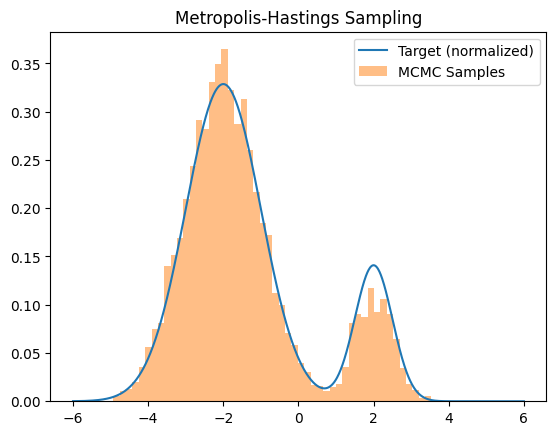

In [7]:
import numpy as np
import matplotlib.pyplot as plt

# Target density: unnormalized posterior
def target_dist(theta):
    return 0.3 * np.exp(-0.5 * ((theta - 2) / 0.5)**2) + \
           0.7 * np.exp(-0.5 * ((theta + 2) / 1.0)**2)

# Metropolis-Hastings sampler
def metropolis_hastings(target, proposal_std=1.0, n_samples=10_000, burn_in=1_000):
    samples = []
    theta = 0.0
    for _ in range(n_samples + burn_in):
        proposal = np.random.normal(theta, proposal_std)
        accept_ratio = min(1, target(proposal) / target(theta))
        if np.random.rand() < accept_ratio:
            theta = proposal
        if _ >= burn_in:
            samples.append(theta)
    return np.array(samples)

samples = metropolis_hastings(target_dist)

# Plot samples
x = np.linspace(-6, 6, 1000)
y = target_dist(x)
plt.plot(x, y / np.trapz(y, x), label="Target (normalized)")
plt.hist(samples, bins=50, density=True, alpha=0.5, label="MCMC Samples")
plt.legend()
plt.title("Metropolis-Hastings Sampling")
plt.show()


## Gibbs Sampling

### Use Case:
When the joint distribution is complex, but **conditional distributions** are known.

### Idea:
Instead of proposing a full $\theta$ at each step, update each component from its **conditional distribution**:

For 2D case:
1. Sample $\theta_1^{(t+1)} \sim p(\theta_1 \mid \theta_2^{(t)})$
2. Sample $\theta_2^{(t+1)} \sim p(\theta_2 \mid \theta_1^{(t+1)})$

Repeat for all parameters.

### Benefits:
- No rejection step
- Converges faster in structured models
- Often used in Bayesian hierarchical models

### Limitation:
- Only works if conditionals are easy to sample from


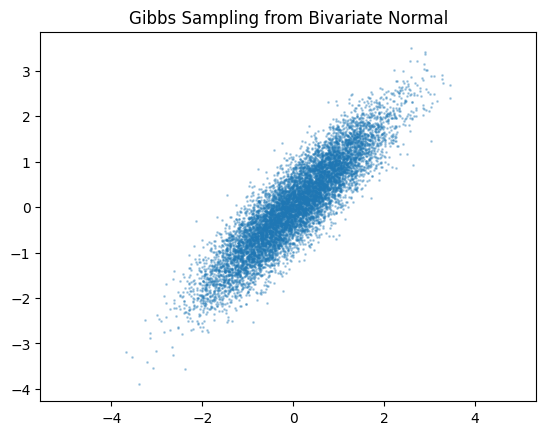

In [9]:
# Gibbs sampling for bivariate normal
mu = np.array([0, 0])
rho = 0.9
sigma1, sigma2 = 1.0, 1.0
n_samples = 10_000
x, y = np.zeros(n_samples), np.zeros(n_samples)

for i in range(1, n_samples):
    x[i] = np.random.normal(rho * y[i - 1], np.sqrt(1 - rho**2))
    y[i] = np.random.normal(rho * x[i], np.sqrt(1 - rho**2))

plt.scatter(x, y, s=1, alpha=0.3)
plt.title("Gibbs Sampling from Bivariate Normal")
plt.axis("equal")
plt.show()


## Further Topics in MCMC

1. Hamiltonian Monte Carlo (HMC) and No-U-Turn Sampler (NUTS)
2. Adaptive MCMC (tune proposal std over time)
3. Diagnosing convergence: trace plots, autocorrelation, Gelman-Rubin statistic
4. MCMC in PyMC or TensorFlow Probability for full Bayesian modeling
